<a href="https://colab.research.google.com/github/MonitSharma/Learn-Quantum-Computing-with-Qiskit/blob/main/Bernstein_Vazirani_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%pip install qiskit
%pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136820 sha256=a75bd6de391e2b9dfe9973c4ef396dec63cde779ae4a7707bc661707dd1eb975
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


# Bernstein-Vazirani Algorithm

In this section, we first introduce the Bernstein-Vazirani problem, its classical solution, and the quantum algorithm to solve it. We then implement the quantum algorithm using Qiskit and run it on both a simulator and a device.

## The Bernstein-Vazirani Algorithm

The Bernstein-Vazirani algorithm, first introduced in [Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473](https://epubs.siam.org/doi/10.1137/S0097539796300921), can be seen as an extension of the Deutsch-Jozsa algorithm we covered in the last section. It showed that there can be advantages in using a quantum computer as a computational tool for more complex problems than the Deutsch-Jozsa problem.

## The Bernstein-Vazirani Problem

We are again given a black-box function $f$, which takes as input a string of bits ($x$), and returns either $0$  or $1$, that is:

Screenshot 2023-07-26 at 15-57-07 Bernstein-Vazirani Algorithm.png

Instead of the function being balanced or constant as in the Deutsch-Jozsa problem, now the function is guaranteed to return the bitwise product of the input with some string, $s$. In other words, given an input , $x$, $f(x) = s.x, (mod 2)$ We are expected to find . As a classical reversible circuit, the Bernstein-Vazirani oracle looks like this:

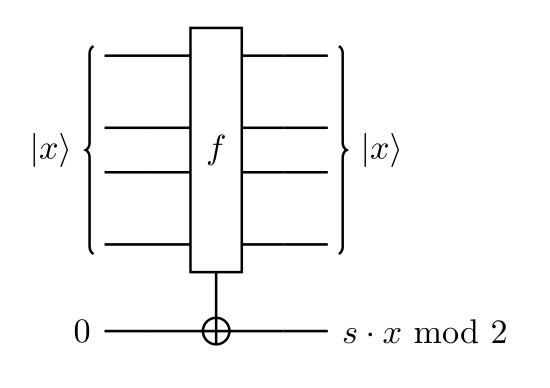

## The Classical Solution

Classically, the oracle returns:

Screenshot 2023-07-26 at 15-58-20 Bernstein-Vazirani Algorithm.png

given an input $x$. Thus, the hidden bit string $s$ can be revealed by querying the oracle with the sequence of inputs:

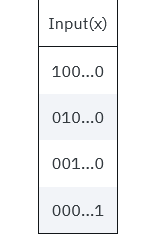

Where each query reveals a different bit of $s$(the bit $s_i$
). For example, with x = 1000...0 one can obtain the least significant bit of $s$, with x = 0100...0 we can find the next least significant, and so on. This means we would need to call the function $f_s(x),n$
, times.

## The Quantum Solution

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$. The quantum Bernstein-Vazirani algorithm to find the hidden bit string is very simple:



1. Initialize the inputs qubits to the $|0⟩^{\otimes n}$ sate, and output qubit to $|-⟩$.
2. Apply Hadamard gates to the input register
3. Query the Oracle
4. Apply Hadamard gates to the input register
5. Measure



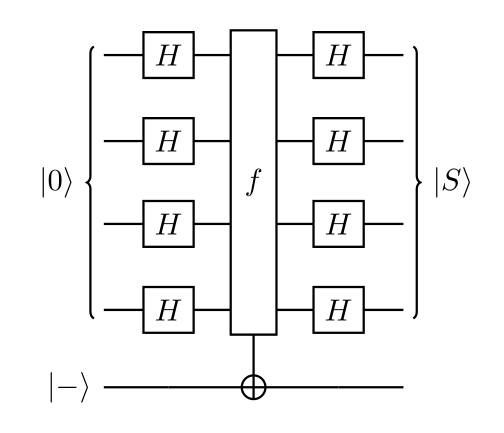

To explain the algorithm, let’s look more closely at what happens when we apply a H-gate to each qubit. If we have an $n$-qubit state, $|a⟩$, and apply the H-gates, we will see the transformation:



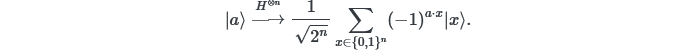

### How?

We remember the Hadamard performs the following transformations on one qubit:

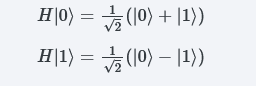

Using summation notation, we could rewrite it like this

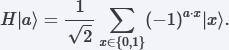

For two qubits, applying a Hadamard to each performs the following transformations:

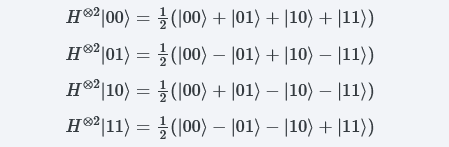

We can express this using the summation below:

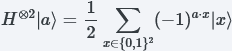

In particular, when we start with a quantum register $|0000.....0⟩$ and apply $n$ Hadamard gates to it, we have the familiar quantum superposition:



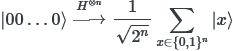

In this case, the phase term $(-1)^{a.x}$ disappears, since $a=0$, and thus $(-1)^{a.x} = 1$.

The classical oracle $f_s$ returns $1$ for any input $x$ such that $s.x \text{ mod } 2 = 1$ , and returns $0$ otherwise. If we use the same phase kickback trick from the Deutsch-Jozsa algorithm and act on a qubit in the state $|-⟩$, we get the following transformation:


Screenshot 2023-07-26 at 16-05-51 Bernstein-Vazirani Algorithm.png


The algorithm to reveal the hidden bit string follows naturally by querying the quantum oracle $f_s$
with the quantum superposition obtained from the Hadamard transformation of $|000...0⟩$. Namely,


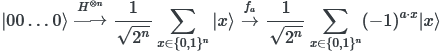

Because the inverse of the $n$ Hadamard gates is again the $n$ Hadamard gates, we can obtain $a$ by


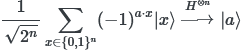

# Example


Let's go through a specific example for qubits and a secret string . Note that we are following the formulation in [Jiangfeng Du, Mingjun Shi, Jihui Wu, Xianyi Zhou, Yangmei Fan, BangJiao Ye, Rongdian Han (2001) "Implementation of a quantum algorithm to solve the Bernstein-Vazirani parity problem without entanglement on an ensemble quantum computer", Phys. Rev. A 64, 042306](https://arxiv.org/abs/quant-ph/0012114) that generates a circuit for the Bernstein-Vazirani quantum oracle using only one register.

1. The register of two qubits is initialized to zero:

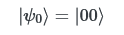

2. Apply a Hadamard gate to both qubits:

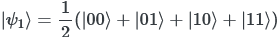

3. For the string $s=11$, the quantum oracle performs the operation:

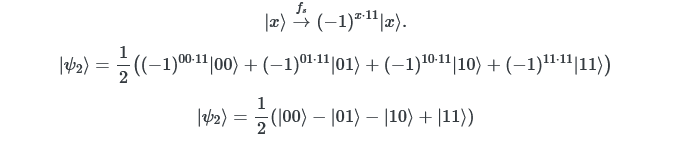

4. Apply a Hadamard gate to both qubits:

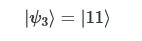

5. Measure to find the secret string  $ s=11$

## Qiskit Implementation

We'll now walk through the Bernstein-Vazirani algorithm implementation in Qiskit for a three bit function with $s=011$.

In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

We first set the number of qubits used in the experiment, and the hidden bit string $s$ to be found by the algorithm. The hidden bit string $s$ determines the circuit for the quantum oracle.

In [2]:
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string

We then use Qiskit to program the Bernstein-Vazirani algorithm.

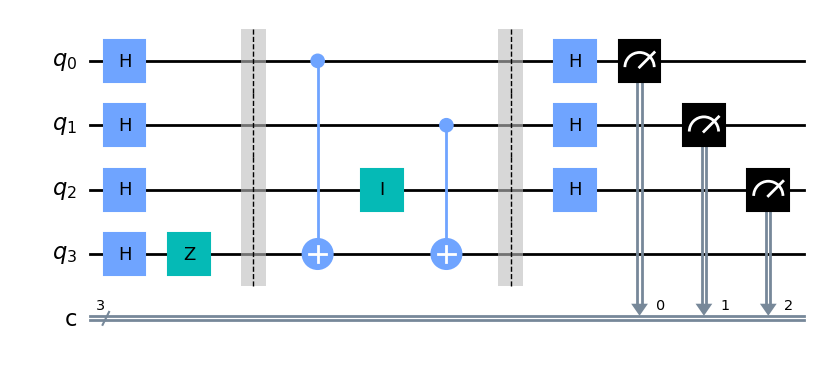

In [3]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Apply barrier
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)

# Apply barrier
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw('mpl')

### Experiment with Simulators

We can run the above circuit on the simulator.

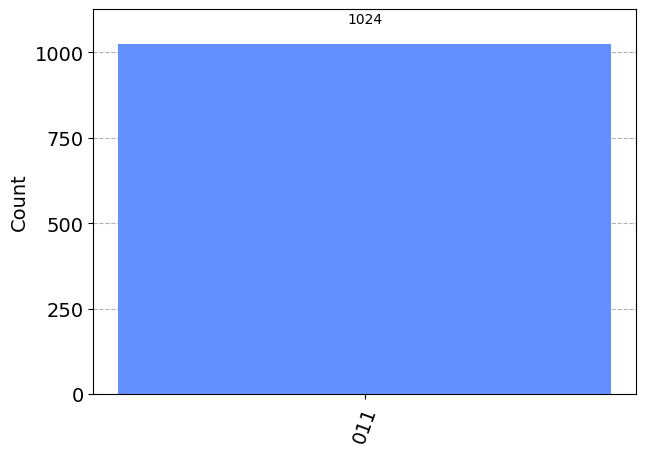

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
results = aer_sim.run(bv_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

We can see that the result of the measurement is the hidden string 011.

## Experiment with Real Devices

We can run the circuit on the real device as below.

In [5]:
from qiskit import IBMQ
IBMQ.save_account('ENTER API TOKEN')

<ipython-input-5-cdf230485926>:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('c5a303670922a83ac5699dc2fea334193919a9e2fe6943debde1ac52815df5e39c6a137e05136088f3a7715e8d6dbd10097baf193df1fa22206a85931166946f')


In [6]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [7]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
job = backend.run(transpiled_bv_circuit, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


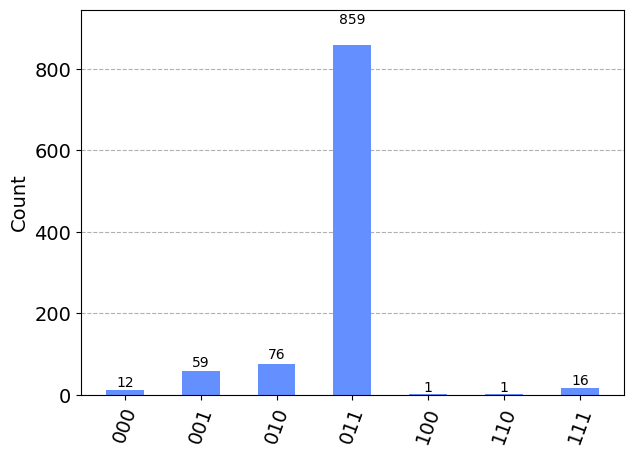

In [8]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, most of the results are 011. The other results are due to errors in the quantum computation.

The above implementation of Bernstein-Vazirani is for a secret bit string $s=011$. Modify the implementation for a secret string $s=1011$.

In [9]:
n = 4 # number of qubits used to represent s
s = '1011'   # the hidden binary string

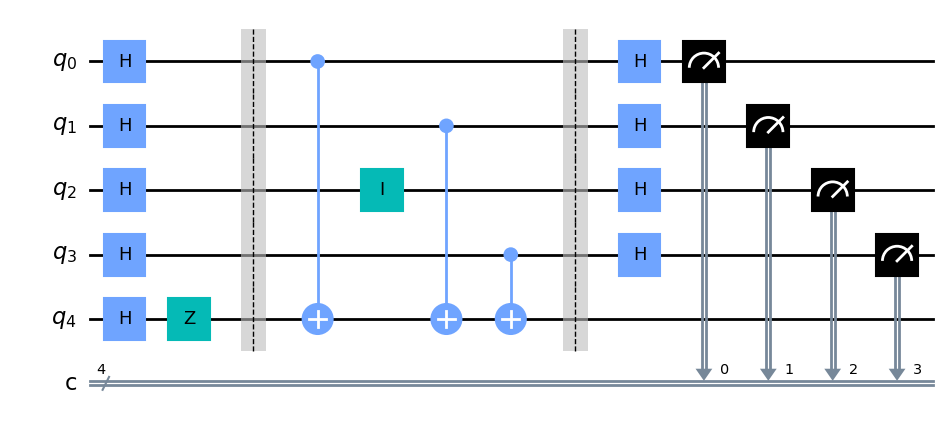

In [10]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Apply barrier
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)

# Apply barrier
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw('mpl')

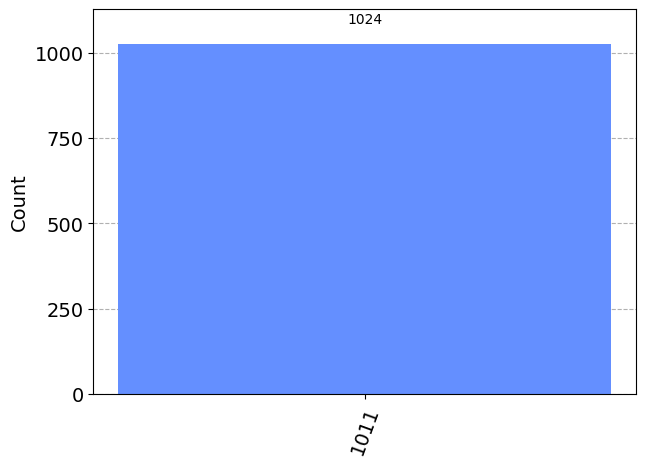

In [11]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
results = aer_sim.run(bv_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

Now try for a bit string $s=11101101$

In [16]:
n = 8 # number of qubits used to represent s
s = '11101101'   # the hidden binary string

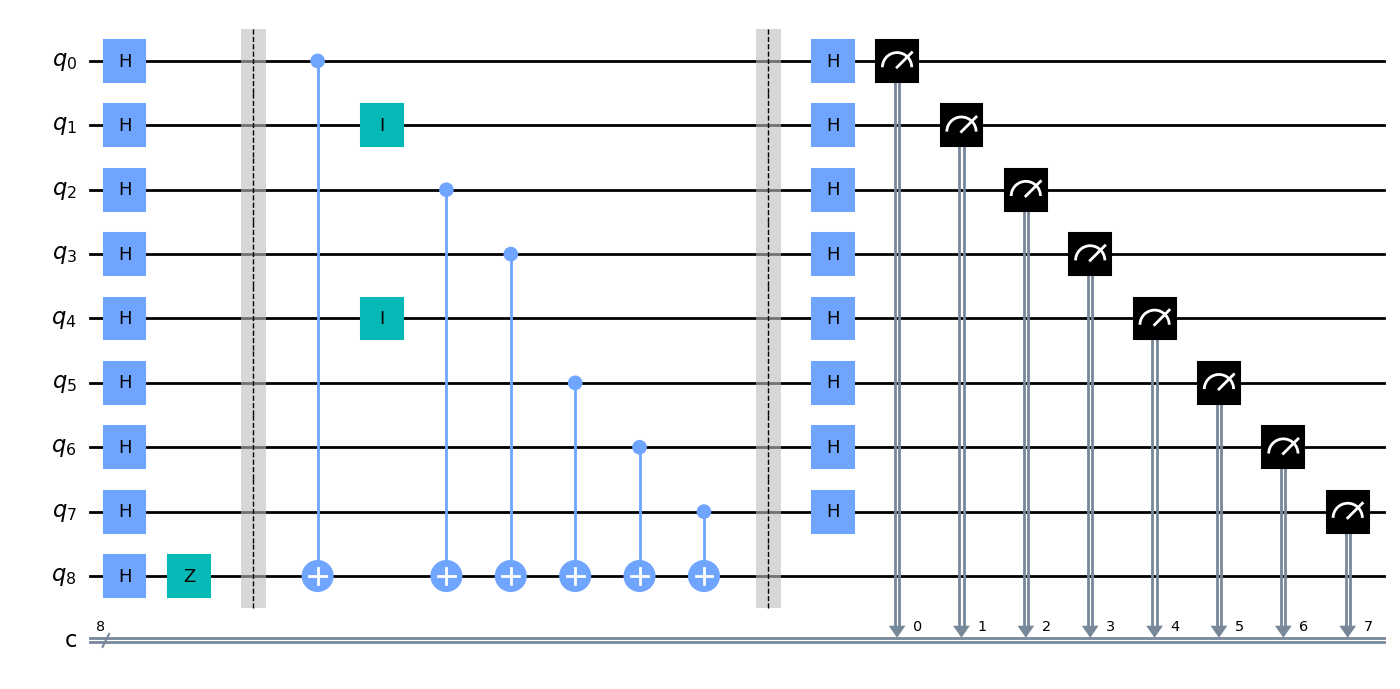

In [17]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Apply barrier
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)

# Apply barrier
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw('mpl')

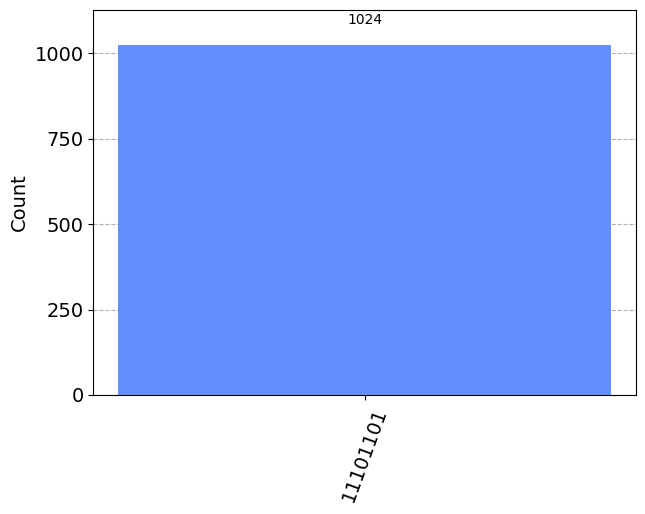

In [18]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
results = aer_sim.run(bv_circuit).result()
answer = results.get_counts()

plot_histogram(answer)